In [1]:
import os.path
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import itertools
import seaborn as sns

from scipy import interpolate
from matplotlib import pyplot as plt

(1000, 2)


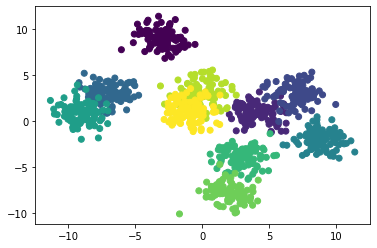

In [24]:
load=True
num_cells = 1000
num_dims_reduced = 2
num_branches = 2
K = 10 # cluster labels
if num_branches == 2:
    filename = 'fakedata-2branch.npy'
    start_node = 5
else:
    filename = 'fakedata-1branch.npy'
    start_node = 4

if load:
    data = np.load(filename, allow_pickle=True).item()
    cluster_labels = data['cluster_labels']
    data = data['data'].numpy()
else:
    cluster_labels = np.zeros([num_cells], dtype=int)
    data = list()
    for k in range(K):
        cells = num_cells // K
        offset = torch.randint(20, torch.Size([2])) - 10
        print(offset.shape)

        data.append(offset + torch.randn(torch.Size([num_cells//K, num_dims_reduced])))
        cluster_labels[k*cells:(k+1)*cells] = k
    data = torch.cat(data)
    np.save(filename, dict(data=data, cluster_labels=cluster_labels))
plt.scatter(data[:, 0], data[:, 1], c=cluster_labels)

cluster_labels_onehot = np.zeros((cluster_labels.shape[0], cluster_labels.max()+1))
cluster_labels_onehot[np.arange(cluster_labels.shape[0]), cluster_labels] = 1

print(data.shape)

  0%|          | 0/10 [00:00<?, ?it/s]

Lineages: [Lineage[5, 3, 9, 8, 0], Lineage[5, 3, 9, 8, 1, 2, 4], Lineage[5, 3, 9, 8, 1, 6, 7]]
Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x7feef3273210>, <pcurve.PrincipalCurve object at 0x7feef35cda10>]
avg pseudotimes interp 27.148570534676526
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x7feef4dcfa90>, <pcurve.PrincipalCurve object at 0x7feef4daebd0>]
avg pseudotimes interp 15.673357598537201
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x7feef4dcfa90>, <pcurve.PrincipalCurve object at 0x7feef4daebd0>]
avg interp [ 0.          1.54405201  2.27544738  3.12614744  3.99022432  4.86149201
  5.33611234  6.3647015  10.33086702 11.14537231 11.14537231 11.14537231
 11.14537231 11.14537231 11.14537231 11.14537231 11.16629856 11.25339545
 11.92375947 12.48850882 13.27627858 14.14114327 14.88716522 15.09752957
 15.09752957 15.10047314 15.10047314 15.10047314 15.10047314 15.100

/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:623: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


avg interp [ 0.          1.54405201  2.27544738  3.12614744  3.99022432  4.86149201
  5.33611234  6.3647015  10.33086702 11.14537231 11.14537231 11.14537231
 11.14537231 11.14537231 11.14537231 11.14537231 11.16629856 11.25339545
 11.92375947 12.48850882 13.27627858 14.14114327 14.88716522 15.09752957
 15.09752957 15.10047314 15.10047314 15.10047314 15.10047314 15.10047314
 15.10047314 15.6733576  15.6733576  15.6733576 ] [[ 0.65798274  4.17764793]
 [ 0.65798274  4.17764793]
 [ 0.65798274  4.17764793]
 ...
 [-2.13230669  1.45746515]
 [-2.20725558  1.47982955]
 [-1.59134987  1.29604589]]
s interp [ 0.          1.54405557  2.2754433   3.12615672  3.99022813  4.85697842
  5.80337117  9.74898795 10.81612095 11.1521745  11.1521745  11.1521745
 11.1521745  11.1521745  11.1521745  11.1521745  11.1521745  11.49633427
 11.89599857 12.13736907 12.44650965 12.71739808 12.98288412 13.2361227
 13.30958773 13.30958773 13.30958773 13.30958773 13.30958773 13.90252129
 17.77598346 19.42221052 20.173162

 10%|█         | 1/10 [00:02<00:21,  2.42s/it]

avg interp [ 0.          1.54405681  2.27544867  3.12614797  3.99022645  4.85587287
  5.33315052  6.15803502  9.8372841  10.88081539 11.1982582  12.39356538
 13.29808051 13.30090775 13.30090775 13.30090775 14.57360786 16.68528283
 17.43952907 18.04246916 18.59102033 19.15961046 19.15961046 19.54826996
 20.92694584 21.71643032 22.20444202 22.59453445 23.18632504 23.74544358
 25.17801151 26.74292439 27.15629025 27.15629025] [[-0.09008287  3.08315816]
 [-0.09008287  3.08315816]
 [-5.4893273   2.45918638]
 ...
 [-2.13231895  1.45746882]
 [-2.20725695  1.47982996]
 [-1.59134937  1.29604572]]
s interp [ 0.          1.54405557  2.2754433   3.12615672  3.99022813  4.85697842
  5.33622997  6.16112114  9.84036918 10.88390268 11.21427017 12.40754993
 13.30958773 13.30958776 13.30958776 13.30958776 14.65572973 16.7173707
 17.51420145 17.97035063 17.97035063 17.97035063 17.97035063 18.69111158
 19.24578547 19.84911338 20.60377063 21.90770537 22.61905831 23.44463841
 25.02562224 26.65779397 27.17622

 20%|██        | 2/10 [00:03<00:13,  1.71s/it]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x7feef3273210>, <pcurve.PrincipalCurve object at 0x7feef4daebd0>]
avg pseudotimes interp 26.886472336457405
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x7feef5b1e510>, <pcurve.PrincipalCurve object at 0x7feef5b40310>]
avg pseudotimes interp 15.702206596250763
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x7feef5b1e510>, <pcurve.PrincipalCurve object at 0x7feef5b40310>]
avg interp [ 0.          1.54405404  2.27544734  3.12614038  3.99022495  4.84802029
  5.33015433  6.3019713  10.28478348 11.13997754 11.13997754 11.13997754
 11.13997754 11.13997754 11.13997754 11.13997754 11.13997754 11.24228025
 11.91405359 12.47820995 13.27273872 13.9941568  14.58116334 15.12030564
 15.12030564 15.12030564 15.12030564 15.12030564 15.12030564 15.12030564
 15.12030564 15.7022066  15.7022066  15.7022066 ] [[ 0.69940413  4.16240804]
 [ 0.6994041

 30%|███       | 3/10 [00:04<00:10,  1.48s/it]

avg interp [ 0.          1.54405534  2.2754481   3.12614212  3.9902261   4.85732397
  5.32678649  6.15166621  9.83091566 10.87444562 11.18894462 12.3803663
 13.2817947  13.2817947  13.2817947  13.30567882 14.54352227 16.69450602
 17.42996194 18.02068747 18.45030485 19.14608543 19.19948642 19.56049908
 20.95851863 21.73335792 22.22365595 22.61486902 23.19071349 23.74374031
 25.18414253 26.74755315 26.90490557 26.90490557] [[-0.090859    3.07820359]
 [-0.090859    3.07820359]
 [-5.48931991  2.45918417]
 ...
 [-2.13232135  1.45746952]
 [-2.20725677  1.47982991]
 [-1.59134965  1.29604583]]
s interp [ 0.          1.54405556  2.27544905  3.12615671  3.9902281   4.84809272
  5.32926363  6.15414621  9.83339349 10.87692683 11.19237559 12.38766619
 13.29439438 13.29439438 13.29439438 13.29439438 14.60558988 16.65587266
 17.43797264 17.94838857 17.94838857 17.94838857 18.00973622 18.86387574
 19.21332151 19.78838285 20.51552403 21.9241237  22.6368741  23.44039836
 25.00698227 26.65427419 27.18511

 40%|████      | 4/10 [00:05<00:07,  1.31s/it]

avg interp [ 0.          1.54405546  2.27544798  3.1261412   3.99022598  4.84759562
  5.32534639  6.15022436  9.82947201 10.87299448 11.19222361 12.37790459
 13.28587949 13.28587949 13.28587949 13.28587949 14.53593035 16.69933389
 17.43328415 18.023715   18.47663466 19.13032423 19.22968957 19.57481921
 20.98631631 21.75321286 22.23021899 22.6330343  23.2074242  23.75129268
 25.19551317 26.75828045 26.78759024 26.78759024] [[-0.08100095  3.07964933]
 [-0.08100095  3.07964933]
 [-5.48931272  2.45918202]
 ...
 [-2.13230199  1.45746375]
 [-2.20725486  1.47982935]
 [-1.59134578  1.29604468]]
s interp [ 0.          1.54405556  2.27544905  3.1261567   3.99022809  4.84773447
  5.32689792  6.15177901  9.83102639 10.87455569 11.14253283 11.18990113
 12.38288355 13.28953153 13.28953153 13.28953153 13.28953154 14.59253014
 16.65247517 17.55805362 17.94211897 17.94211897 17.94211897 18.39150439
 20.03322285 21.20602032 21.20602032 22.61877895 25.40678689 26.20189658
 26.91872677 28.36835409 28.9998

 50%|█████     | 5/10 [00:07<00:06,  1.27s/it]

avg interp [ 0.          1.54405561  2.27544808  3.12614038  3.99022591  4.83650814
  5.32397077  6.14885055  9.82809834 10.87160222 11.19693732 12.32036136
 13.26976661 13.29173646 13.29173646 13.29173646 14.51935201 16.70177067
 17.4366565  18.02712642 18.47551446 19.1163888  19.25900815 19.5891308
 21.02327878 21.77855782 22.2394358  22.64448322 23.2185675  23.75904458
 25.20738273 26.67327044 26.67327044 26.67327044] [[-0.07159758  3.07742781]
 [-0.07287984  3.07678859]
 [-5.48931095  2.4591815 ]
 ...
 [-2.13230183  1.45746371]
 [-2.20725477  1.47982933]
 [-1.5913468   1.29604499]]
s interp [ 0.          1.54405555  2.27544904  3.12615669  3.99022808  4.84766888
  5.32547731  6.15035688  9.82960441 10.87313092 11.18869816 12.37980407
 13.28690362 13.28690362 13.28690362 13.28690362 14.58218691 16.65317663
 17.4348851  17.93902006 17.93902006 17.93902006 18.13117106 18.99634081
 19.26081909 19.79179909 20.47970783 21.95837096 22.68221251 23.47118446
 25.01946059 26.68308823 27.22343

 60%|██████    | 6/10 [00:09<00:05,  1.49s/it]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x7feef3c01a90>, <pcurve.PrincipalCurve object at 0x7feef4dc9190>]
avg pseudotimes interp 26.426384929157358
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x7feef3c01490>, <pcurve.PrincipalCurve object at 0x7feef3823710>]
avg pseudotimes interp 15.771720334906309
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x7feef3c01490>, <pcurve.PrincipalCurve object at 0x7feef3823710>]
avg interp [ 0.          1.54405273  2.27544689  3.12613816  3.99022285  4.84710578
  5.32530236  6.26327973 10.06568609 11.13006843 11.13006843 11.13006843
 11.13006843 11.13006843 11.13006843 11.14880261 11.14880261 11.45804351
 12.05945051 12.88836866 13.40421875 14.19893923 14.58681539 15.16137785
 15.16137785 15.16137785 15.16137785 15.16137785 15.16137785 15.16137785
 15.16137785 15.77172033 15.77172033 15.77172033] [[ 0.78619852  4.07969297]
 [ 0.7861985

 70%|███████   | 7/10 [00:10<00:04,  1.51s/it]

Shrinking branch @1 with curves: [<pcurve.PrincipalCurve object at 0x7feef3c01a90>, <pcurve.PrincipalCurve object at 0x7feef4dc9190>]
avg interp [ 0.          1.54405558  2.27544801  3.12613882  3.99022572  4.84765414
  5.32238891  6.14726768  9.82651552 10.86995635 11.18008022 12.26001597
 13.26381324 13.28658407 13.28658407 13.28658407 14.42687405 16.69725771
 17.43410955 18.02948347 18.48108216 19.04976892 19.31684546 19.54113433
 21.06252675 21.78915157 22.24983805 22.6555664  23.23887287 23.77406459
 25.23010149 26.45625355 26.45625355 26.45625355] [[-0.06830062  3.07711127]
 [-0.07240681  3.07508246]
 [-5.48930861  2.4591808 ]
 ...
 [-2.13230177  1.45746369]
 [-2.20725471  1.47982931]
 [-1.59134659  1.29604493]]
s interp [ 0.          1.54405558  2.27544903  3.12615668  3.99022807  4.8471229
  5.32309243  6.14797071  9.82721839 10.87073322 11.13883589 11.1901803
 12.37584096 13.28259541 13.28259541 13.28259541 13.28259541 14.56342192
 16.67123964 17.51201028 17.93620373 17.936203

 80%|████████  | 8/10 [00:11<00:02,  1.41s/it]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x7feef56a04d0>, <pcurve.PrincipalCurve object at 0x7feef4f16050>]
avg pseudotimes interp 26.22858389361344
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x7feef56a0790>, <pcurve.PrincipalCurve object at 0x7feef3cb04d0>]
avg pseudotimes interp 15.808038196454191
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x7feef56a0790>, <pcurve.PrincipalCurve object at 0x7feef3cb04d0>]
avg interp [ 0.          1.5440544   2.27544504  3.12613638  3.99022291  4.83065773
  5.32065594  6.21813511  9.98679623 11.1276441  11.1276441  11.1276441
 11.1276441  11.1276441  11.1276441  11.14860285 11.14860285 11.45896065
 12.06899251 12.93207651 13.58055604 14.25259781 14.59925517 15.18087609
 15.18087609 15.18087609 15.18087609 15.18087609 15.18087609 15.18087609
 15.18087609 15.8080382  15.8080382  15.8080382 ] [[ 0.82900019  4.02446145]
 [ 0.82900019 

 90%|█████████ | 9/10 [00:13<00:01,  1.38s/it]

avg interp [ 0.          1.54405547  2.27544799  3.12613786  3.99022557  4.83657006
  5.32026577  6.14514129  9.82438919 10.86778582 11.17687162 12.25328665
 13.26603905 13.27323743 13.27323743 13.27323743 14.42332952 16.70841054
 17.44327068 18.01784673 18.48687151 18.86927757 19.36802055 19.40132924
 21.10748564 21.82462624 22.2710803  22.66676605 23.25904036 23.73658367
 25.29561627 26.26005309 26.26005309 26.26005309] [[-0.07513192  3.07727427]
 [-0.07513192  3.07727427]
 [-5.48930723  2.45918039]
 ...
 [-2.13230151  1.45746361]
 [-2.20725462  1.47982929]
 [-1.59134587  1.29604472]]
s interp [ 0.          1.54405558  2.27544903  3.12615667  3.99022805  4.84681405
  5.3212519   6.14612927  9.82537706 10.86885932 11.13697364 11.18030532
 12.31263419 13.27802482 13.27802482 13.27802482 13.27802482 14.48845521
 16.666777   17.45860061 17.93394391 17.93394391 17.93394391 18.62598542
 20.19747872 20.67560658 20.67560658 22.15098113 24.44474602 25.16402717
 25.74943542 27.28586407 27.9299

100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


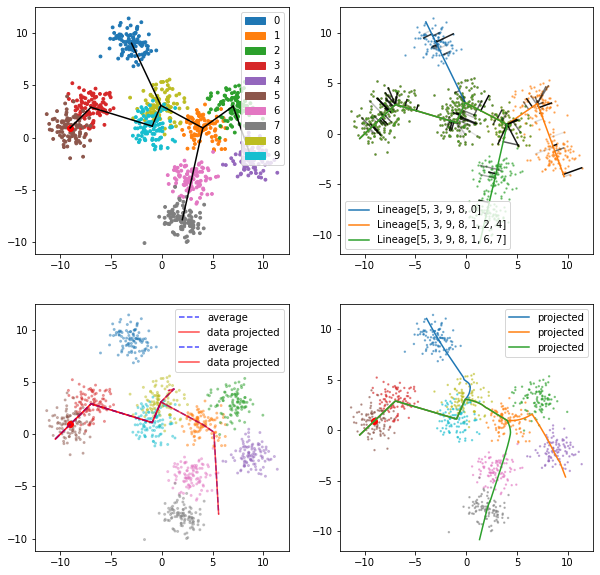

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
custom_xlim = (-12, 12)
custom_ylim = (-12, 12)
# plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)

from slingshot import Slingshot

slingshot = Slingshot(data, cluster_labels_onehot, start_node=start_node, debug_level='verbose')

slingshot.fit(num_epochs=10, debug_axes=axes)

In [ ]:
tttttt


In [ ]:
def scipy_interpolate():
    x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/8)
    y = np.sin(x)

    tck = interpolate.splrep(x, y, s=0.5)
    xnew = np.arange(0, 2*np.pi, np.pi/50)

    ynew = interpolate.splev(xnew, tck, der=0)

    plt.plot(xnew, ynew)
    plt.plot(xnew, np.sin(xnew))


